- # FUNMAN Approach:
  - Identify regions of parameter space that satisfy operational constraints
  - Compile model and operational constraints into first-order logic w/ theory of nonlinear real arithmetic (Satisfiabily Modulo Theory, SMT)
  - Solve series of SMT instances (proving unsatisfiability) to label regions.  Two subproblems: 1) identify a region to check, 2) determine how to check
- # Phase Goals: 
  - Improve Scalability
  - Expand Models 
  - Feedback to TA1 and TA3
- # Status: 
  - Scalability: MCTS in dReal solver (exponential speedup in precision) (subproblem 2, above)
  - Models: Petrinet, Regnet, Bilayers (multiple formats)
  - API: Submit Request, Get results anytime, Halt job
  - Integration: building on Terrarium, ready for deployment and TA3 usage
- # Ongoing Work: 
  - Variable Elimination in SMT Encodings (subproblem 2, above)
  - Exists Forall encodings (subproblem 1, above)
  - API support for new models 


![FunMAn Overview](./funman-diagram.png)

# Demo Setup

In [1]:
# Common imports
import asyncio
import nest_asyncio
import os
import json
from pathlib import Path

from IPython.display import JSON

# Setup URLs
API_BASE_PATH = os.path.join(os.getcwd(), "..")
# Currently assumes a localhost server us running (see funman_server.ipynb)
API_SERVER_HOST = "127.0.0.1"
API_SERVER_PORT = 8190
SERVER_URL = f"http://{API_SERVER_HOST}:{API_SERVER_PORT}"
OPENAPI_URL = f"{SERVER_URL}/openapi.json"
CLIENT_NAME = "funman-api-client"

# Setup Paths
RESOURCES = Path("../resources").resolve()


# Install API client to the working directory
# and add the install to the sys path
import funman.api.client as client
client.make_client(
    API_BASE_PATH, openapi_url=OPENAPI_URL, client_name=CLIENT_NAME
)
nest_asyncio.apply()


# Setup API client request
from funman_api_client import Client
from funman_api_client.api.default import (
    post_queries_queries_post,
    get_queries_queries_query_id_get,
)
from funman_api_client.models.body_post_queries_queries_post import BodyPostQueriesQueriesPost
from funman_api_client.models import (
    BilayerModel,
    FUNMANConfig,
    LabeledParameter,
    QueryLE,
    FunmanWorkRequest,
    FunmanWorkUnit,
    FunmanResults,
    QueryTrue,
    GeneratedPetriNetModel
    
)

# Create a funman client
funman_client = Client(SERVER_URL, timeout=None)

Updating existing funman client at /root/funman from http://127.0.0.1:8190/openapi.json
Updating funman_api_client


---
---
# Example 1: AMR Petrinet
## Question: Can we verify the parameter bounds given in the AMR prevent > 30% maximum infections?
---
## Example 1: Step 1: Load Model and Request

In [2]:
EXAMPLE_DIR = RESOURCES / "amr" / "petrinet" / "amr-examples"
MODEL_PATH = EXAMPLE_DIR / "sir.json"
REQUEST_PATH = EXAMPLE_DIR / "sir_request1.json"

# Read in the model file
model = json.loads(MODEL_PATH.read_bytes())
# pretty print
# print(json.dumps(model, indent=2))

# Read in the funman request file
request = json.loads(REQUEST_PATH.read_bytes())
# pretty print
print(json.dumps(request, indent=2))

{
  "query": {
    "queries": [
      {
        "variable": "S",
        "lb": 0.0
      },
      {
        "variable": "S",
        "ub": 1001.0
      },
      {
        "variable": "I",
        "lb": 0.0
      },
      {
        "variable": "I",
        "ub": 300.0
      },
      {
        "variable": "R",
        "lb": 0.0
      },
      {
        "variable": "R",
        "ub": 1001.0
      }
    ]
  },
  "parameters": [
    {
      "name": "beta",
      "lb": 0.0002603,
      "ub": 0.0002803,
      "label": "all"
    },
    {
      "name": "gamma",
      "lb": 0.1,
      "ub": 0.18,
      "label": "all"
    },
    {
      "name": "S0",
      "lb": 1000,
      "ub": 1000,
      "label": "any"
    },
    {
      "name": "I0",
      "lb": 1,
      "ub": 1,
      "label": "any"
    },
    {
      "name": "R0",
      "lb": 0,
      "ub": 0,
      "label": "any"
    }
  ],
  "structure_parameters": [
    {
      "name": "num_steps",
      "lb": 5,
      "ub": 5,
      "label": "all"
    

## Example 1: Step 2: Submit job

In [3]:
# Make a POST request to the API endpoint
response = asyncio.run(
    post_queries_queries_post.asyncio_detailed(
        client=funman_client,
        json_body=BodyPostQueriesQueriesPost.from_dict({
            "model": model,
            "request": request
        }),
    )
)

# The response returns a work unit
work_unit = FunmanWorkUnit.from_dict(
    src_dict=json.loads(response.content.decode())
)
# Where the id can be used to pull ongoing results
work_unit.id

'd225b8ee-970d-41c5-ad63-54727ee40865'

## Example 1: Step 3: Request results

In [4]:
# Make a GET request to the API endpoint
response = asyncio.run(get_queries_queries_query_id_get.asyncio_detailed(
    work_unit.id,
    client=funman_client
))
# The response returns the latest funman results for the query
results = FunmanResults.from_dict(
    src_dict=json.loads(response.content.decode())
)
# pretty print the parameter_space
print(json.dumps(results.parameter_space.to_dict(), indent=2))

{
  "num_dimensions": 7,
  "true_boxes": [
    {
      "label": "true",
      "bounds": {
        "beta": {
          "lb": 0.0002603,
          "ub": 0.0002803
        },
        "gamma": {
          "lb": 0.1,
          "ub": 0.18
        },
        "S0": {
          "lb": 1000.0,
          "ub": 1000.0
        },
        "I0": {
          "lb": 1.0,
          "ub": 1.0
        },
        "R0": {
          "lb": 0.0,
          "ub": 0.0
        },
        "num_steps": {
          "lb": 5.0,
          "ub": 5.0
        },
        "step_size": {
          "lb": 10.0,
          "ub": 10.0
        }
      }
    }
  ],
  "false_boxes": [],
  "true_points": [
    {
      "values": {
        "beta": 0.00026898103879968585,
        "gamma": 0.13499834440937225,
        "S0": 1000.0,
        "I0": 1.0,
        "R0": 0.0,
        "num_steps": 5.0,
        "step_size": 10.0
      },
      "label": "true"
    }
  ],
  "false_points": []
}


## Example 1: Step 4: Plot Results

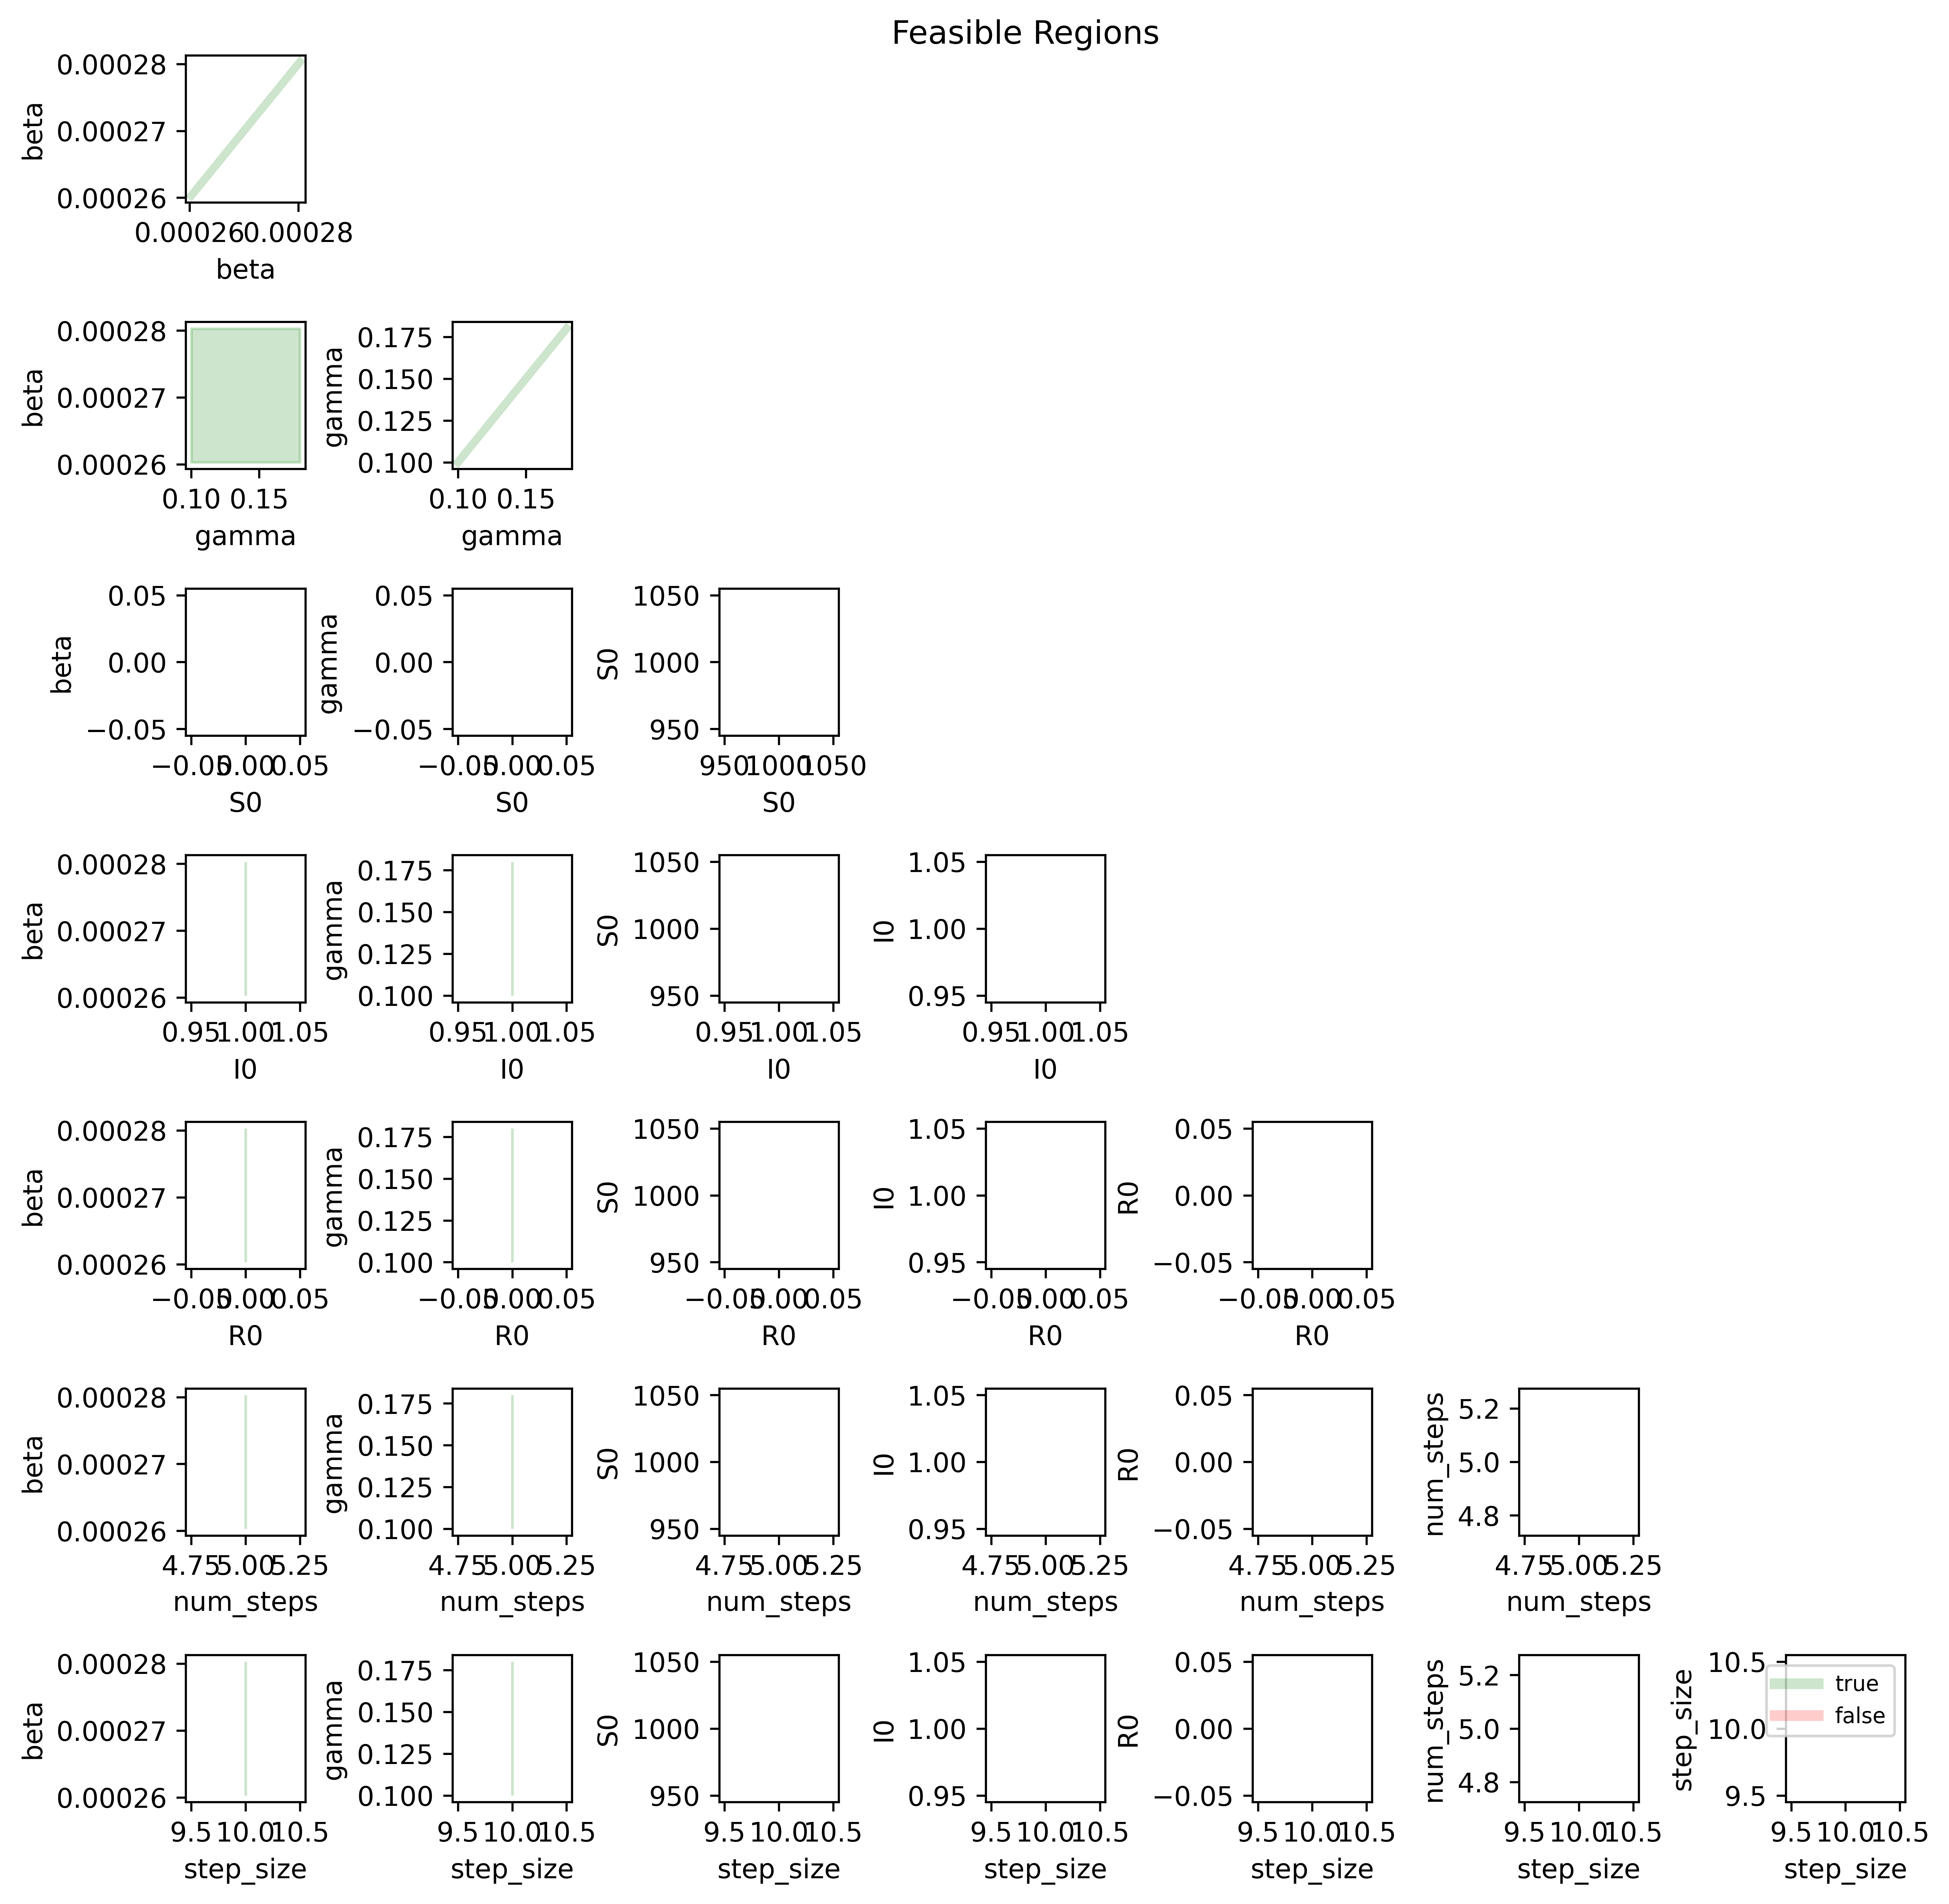

In [5]:
# Plot the ParameterSpace
from funman_demo.parameter_space_plotter import ParameterSpacePlotter
ParameterSpacePlotter(results.parameter_space).plot(show=True)

# Example 1: Optional: Halt Processing Job

In [ ]:
# Halt the current run
from funman_api_client.api.default import (
    halt_queries_query_id_halt_get
)

response = asyncio.run(
    halt_queries_query_id_halt_get.asyncio_detailed(
        client=funman_client,
        query_id=work_unit.id
    )
)

# The response returns a status
response

Response(status_code=<HTTPStatus.OK: 200>, content=b'"Success"', headers=Headers({'date': 'Tue, 27 Jun 2023 14:17:22 GMT', 'server': 'uvicorn', 'content-length': '9', 'content-type': 'application/json'}), parsed='Success')

---
---
# Example 1a: AMR Petrinet
## Question: Can we push beta up and gamma down?
---
## Example 1: Step 1: Load Model and Request

In [6]:
EXAMPLE_DIR = RESOURCES / "amr" / "petrinet" / "amr-examples"
MODEL_PATH = EXAMPLE_DIR / "sir.json"
REQUEST_PATH = EXAMPLE_DIR / "sir_request1a.json"

# Read in the model file
model = json.loads(MODEL_PATH.read_bytes())
# pretty print
# print(json.dumps(model, indent=2))

# Read in the funman request file
request = json.loads(REQUEST_PATH.read_bytes())
# pretty print
print(json.dumps(request, indent=2))

{
  "query": {
    "queries": [
      {
        "variable": "S",
        "lb": 0.0
      },
      {
        "variable": "S",
        "ub": 1001.0
      },
      {
        "variable": "I",
        "lb": 0.0
      },
      {
        "variable": "I",
        "ub": 300.0
      },
      {
        "variable": "R",
        "lb": 0.0
      },
      {
        "variable": "R",
        "ub": 1001.0
      }
    ]
  },
  "parameters": [
    {
      "name": "beta",
      "lb": 0.0002603,
      "ub": 0.0004,
      "label": "all"
    },
    {
      "name": "gamma",
      "lb": 0.0999,
      "ub": 0.1,
      "label": "all"
    },
    {
      "name": "S0",
      "lb": 1000,
      "ub": 1000,
      "label": "any"
    },
    {
      "name": "I0",
      "lb": 1,
      "ub": 1,
      "label": "any"
    },
    {
      "name": "R0",
      "lb": 0,
      "ub": 0,
      "label": "any"
    }
  ],
  "structure_parameters": [
    {
      "name": "num_steps",
      "lb": 5,
      "ub": 5,
      "label": "all"
    }

## Example 1a: Step 2: Submit job

In [10]:
# Make a POST request to the API endpoint
response = asyncio.run(
    post_queries_queries_post.asyncio_detailed(
        client=funman_client,
        json_body=BodyPostQueriesQueriesPost.from_dict({
            "model": model,
            "request": request
        }),
    )
)

# The response returns a work unit
work_unit = FunmanWorkUnit.from_dict(
    src_dict=json.loads(response.content.decode())
)
# Where the id can be used to pull ongoing results
work_unit.id

'962906a7-96eb-4d40-96e8-946711c54a5f'

## Example 1a: Step 3: Request results

In [13]:
# Make a GET request to the API endpoint
response = asyncio.run(get_queries_queries_query_id_get.asyncio_detailed(
    work_unit.id,
    client=funman_client
))
# The response returns the latest funman results for the query
results = FunmanResults.from_dict(
    src_dict=json.loads(response.content.decode())
)
# pretty print the parameter_space
print(json.dumps(results.parameter_space.to_dict(), indent=2))

{
  "num_dimensions": 7,
  "true_boxes": [
    {
      "label": "true",
      "bounds": {
        "beta": {
          "lb": 0.00026030000000000004,
          "ub": 0.00033015000000000003
        },
        "gamma": {
          "lb": 0.09995000000000001,
          "ub": 0.1
        },
        "S0": {
          "lb": 1000.0,
          "ub": 1000.0
        },
        "I0": {
          "lb": 1.0,
          "ub": 1.0
        },
        "R0": {
          "lb": 0.0,
          "ub": 0.0
        },
        "num_steps": {
          "lb": 5.0,
          "ub": 5.0
        },
        "step_size": {
          "lb": 10.0,
          "ub": 10.0
        }
      }
    },
    {
      "label": "true",
      "bounds": {
        "beta": {
          "lb": 0.00029522500000000003,
          "ub": 0.00033015000000000003
        },
        "gamma": {
          "lb": 0.0999,
          "ub": 0.09992500000000001
        },
        "S0": {
          "lb": 1000.0,
          "ub": 1000.0
        },
        "I0": {
    

## Example 1a: Step 4: Plot Results

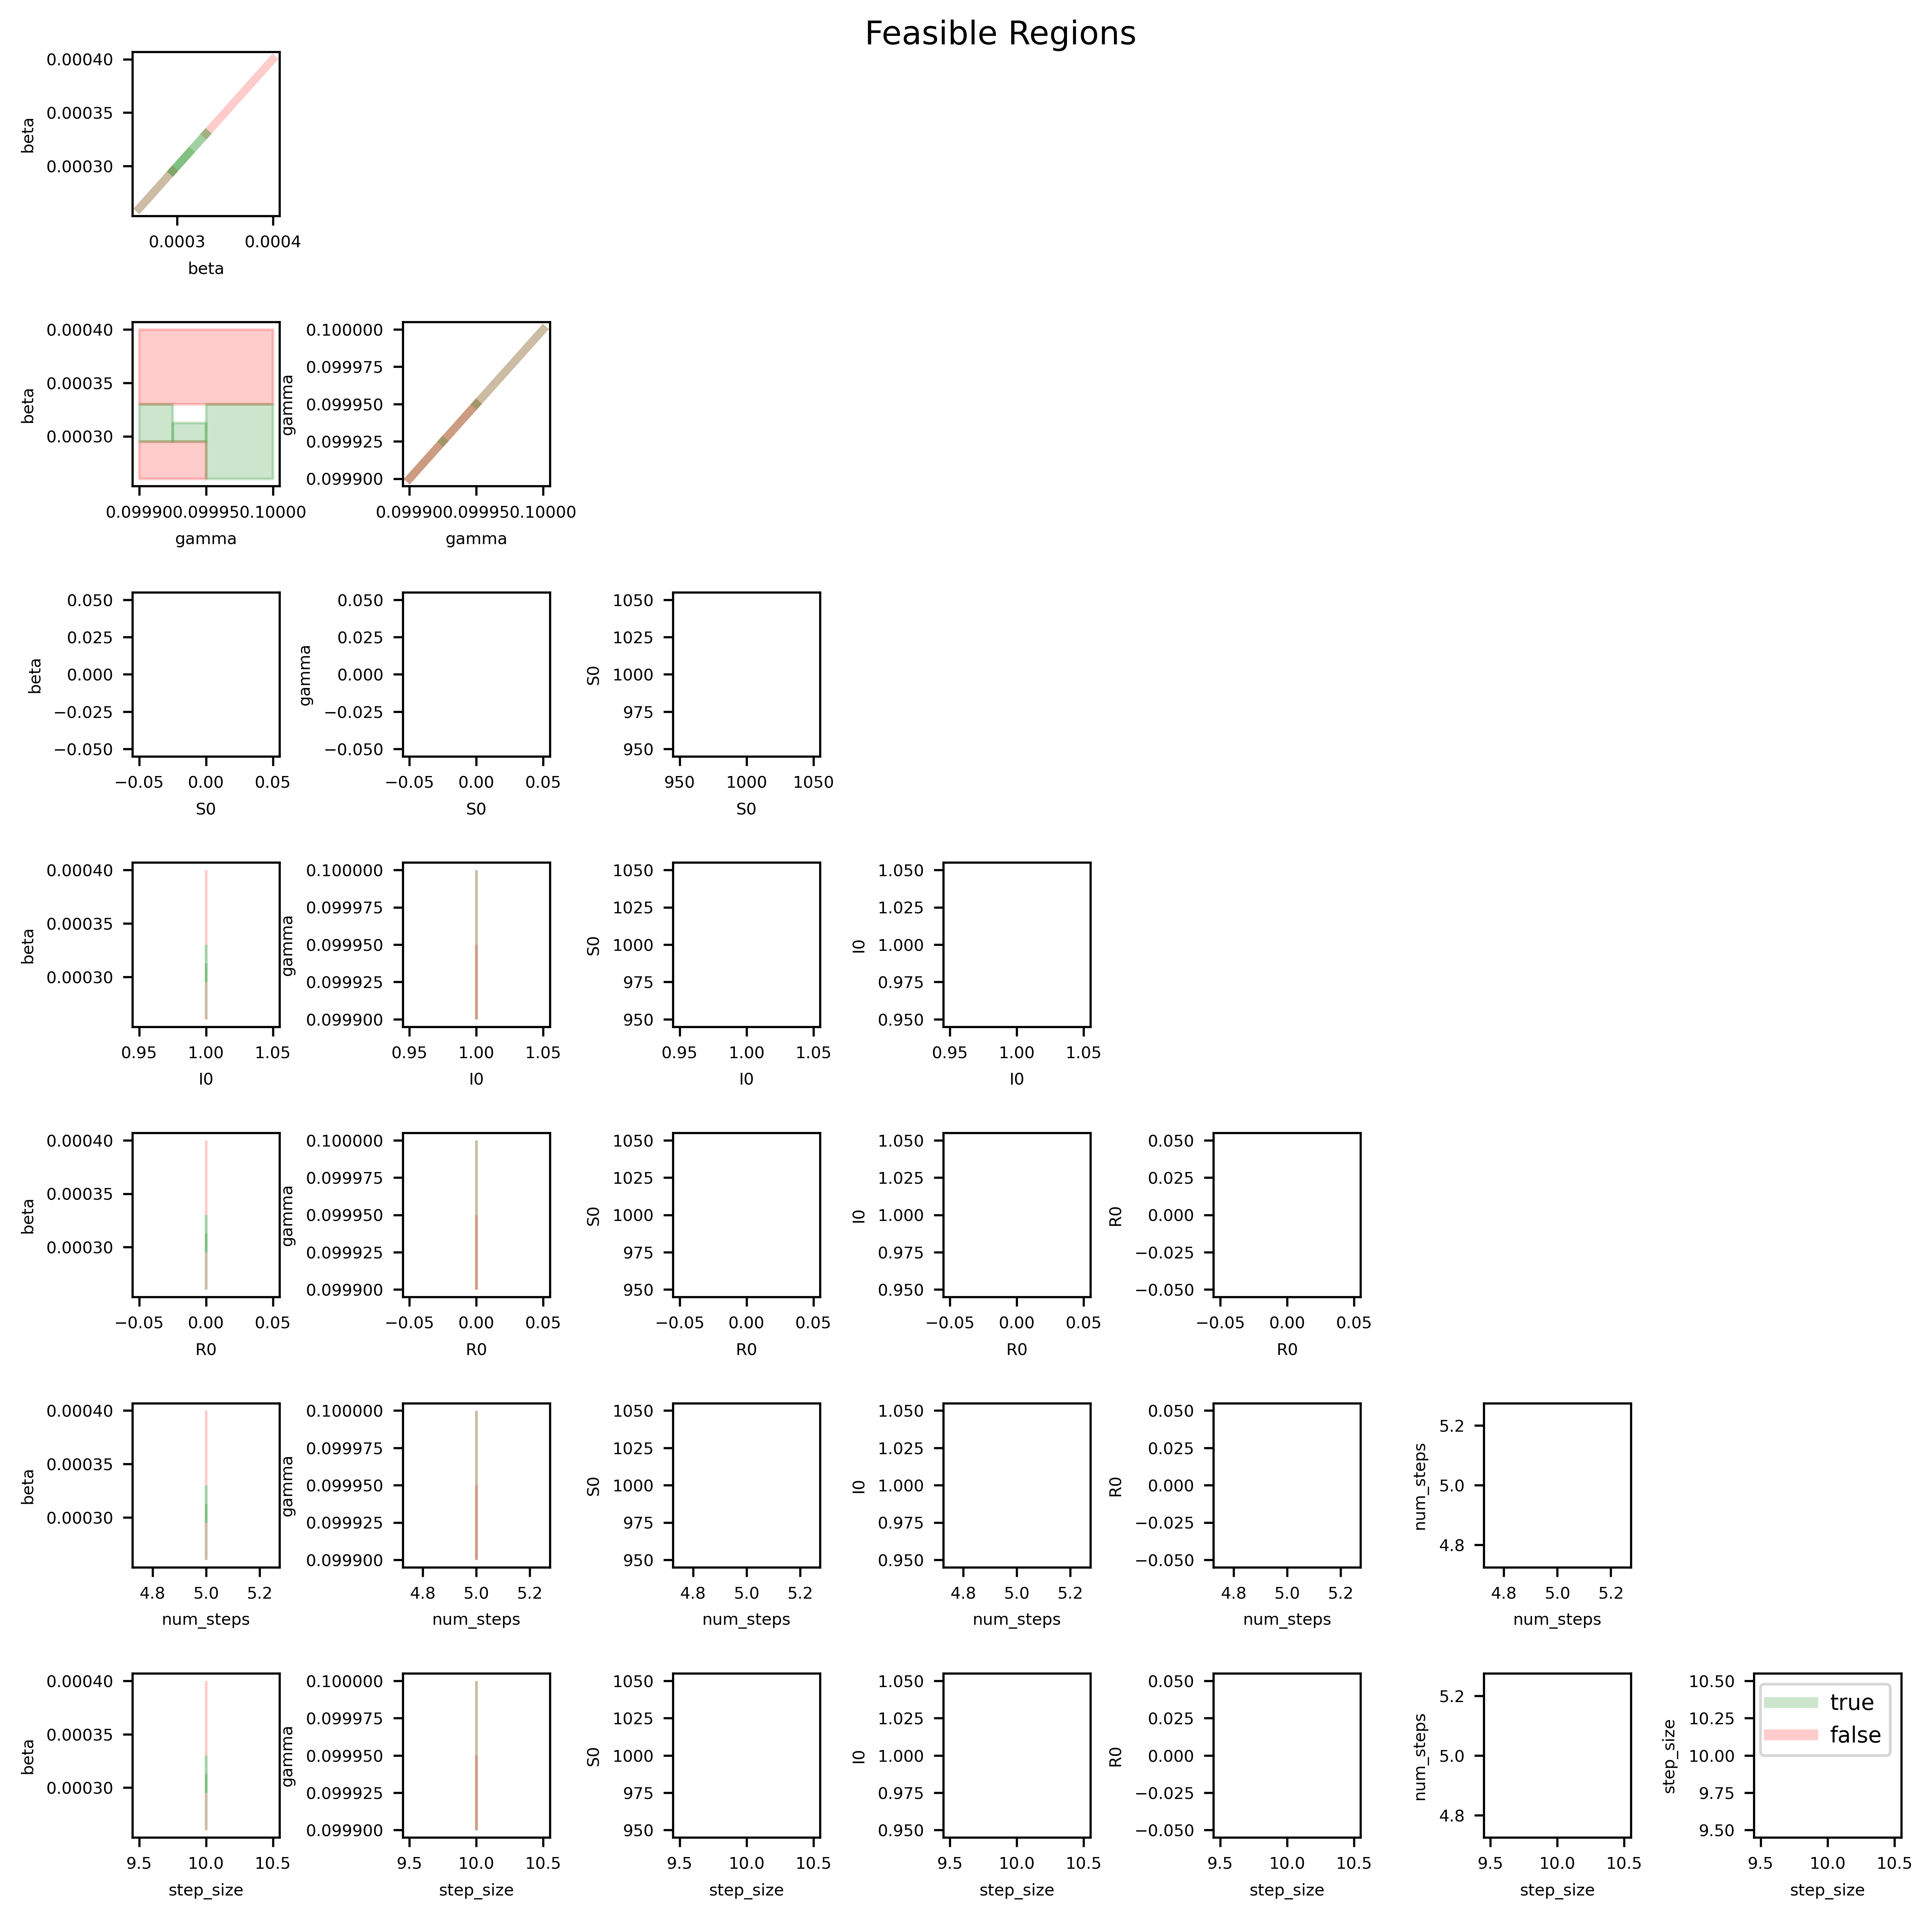

In [14]:
# Plot the ParameterSpace
from funman_demo.parameter_space_plotter import ParameterSpacePlotter
ParameterSpacePlotter(results.parameter_space).plot(show=True)

# Example 1: Optional: Halt Processing Job

In [ ]:
# Halt the current run
from funman_api_client.api.default import (
    halt_queries_query_id_halt_get
)

response = asyncio.run(
    halt_queries_query_id_halt_get.asyncio_detailed(
        client=funman_client,
        query_id=work_unit.id
    )
)

# The response returns a status
response

Response(status_code=<HTTPStatus.OK: 200>, content=b'"Success"', headers=Headers({'date': 'Tue, 27 Jun 2023 14:17:22 GMT', 'server': 'uvicorn', 'content-length': '9', 'content-type': 'application/json'}), parsed='Success')

---
---
# Example 1c: Skema AMR Petrinet
## Question: Can we identify relevant parameter values when no ranges are extracted?
---
## Example 1c: Step 1: Load Model and Request

In [16]:
EXAMPLE_DIR = RESOURCES / "amr" / "petrinet" / "skema"
MODEL_PATH = EXAMPLE_DIR / "linked_petrinet.json"
REQUEST_PATH = EXAMPLE_DIR / "sir_request_skema1.json"

# Read in the model file
model = json.loads(MODEL_PATH.read_bytes())
# pretty print
# print(json.dumps(model, indent=2))

# Read in the funman request file
request = json.loads(REQUEST_PATH.read_bytes())
# pretty print
print(json.dumps(request, indent=2))

{
  "query": {
    "queries": [
      {
        "variable": "S",
        "lb": 0.0
      },
      {
        "variable": "S",
        "ub": 1001.0
      },
      {
        "variable": "I",
        "lb": 0.0
      },
      {
        "variable": "I",
        "ub": 500.0
      },
      {
        "variable": "R",
        "lb": 0.0
      },
      {
        "variable": "R",
        "ub": 1001.0
      }
    ]
  },
  "parameters": [
    {
      "name": "\u03b2",
      "label": "any"
    },
    {
      "name": "\u03b3",
      "label": "any"
    },
    {
      "name": "S0",
      "lb": 1000,
      "ub": 1000,
      "label": "any"
    },
    {
      "name": "I0",
      "lb": 1,
      "ub": 1,
      "label": "any"
    },
    {
      "name": "R0",
      "lb": 0,
      "ub": 0,
      "label": "any"
    }
  ],
  "structure_parameters": [
    {
      "name": "num_steps",
      "lb": 1,
      "ub": 20,
      "label": "all"
    },
    {
      "name": "step_size",
      "lb": 5,
      "ub": 5,
      "labe

## Example 1c: Step 2: Submit job

In [17]:
# Make a POST request to the API endpoint
response = asyncio.run(
    post_queries_queries_post.asyncio_detailed(
        client=funman_client,
        json_body=BodyPostQueriesQueriesPost.from_dict({
            "model": model,
            "request": request
        }),
    )
)

# The response returns a work unit
work_unit = FunmanWorkUnit.from_dict(
    src_dict=json.loads(response.content.decode())
)
# Where the id can be used to pull ongoing results
work_unit.id

'adf8b084-a9aa-4414-ade8-b3503391d13e'

## Example 1c: Step 3: Request results

In [19]:
# Make a GET request to the API endpoint
response = asyncio.run(get_queries_queries_query_id_get.asyncio_detailed(
    work_unit.id,
    client=funman_client
))
# The response returns the latest funman results for the query
results = FunmanResults.from_dict(
    src_dict=json.loads(response.content.decode())
)
# pretty print the parameter_space
print(json.dumps(results.parameter_space.to_dict(), indent=2))

{
  "num_dimensions": 7,
  "true_boxes": [],
  "false_boxes": [],
  "true_points": [
    {
      "values": {
        "S0": 1000.0,
        "I0": 1.0,
        "R0": 0.0,
        "\u03b2": 0.149901123046875,
        "\u03b3": 148.48818359375002,
        "num_steps": 1.0,
        "step_size": 5.0
      },
      "label": "true"
    },
    {
      "values": {
        "S0": 1000.0,
        "I0": 1.0,
        "R0": 0.0,
        "\u03b2": 0.09989999999999999,
        "\u03b3": 100.1,
        "num_steps": 2.0,
        "step_size": 5.0
      },
      "label": "true"
    },
    {
      "values": {
        "S0": 1000.0,
        "I0": 1.0,
        "R0": 0.0,
        "\u03b2": 0.05200588083869345,
        "\u03b3": 52.20588083869346,
        "num_steps": 3.0,
        "step_size": 5.0
      },
      "label": "true"
    },
    {
      "values": {
        "S0": 1000.0,
        "I0": 1.0,
        "R0": 0.0,
        "\u03b2": 0.09521265842367262,
        "\u03b3": 95.4126584236726,
        "num_steps": 4

## Example 1c: Step 4: Plot Results

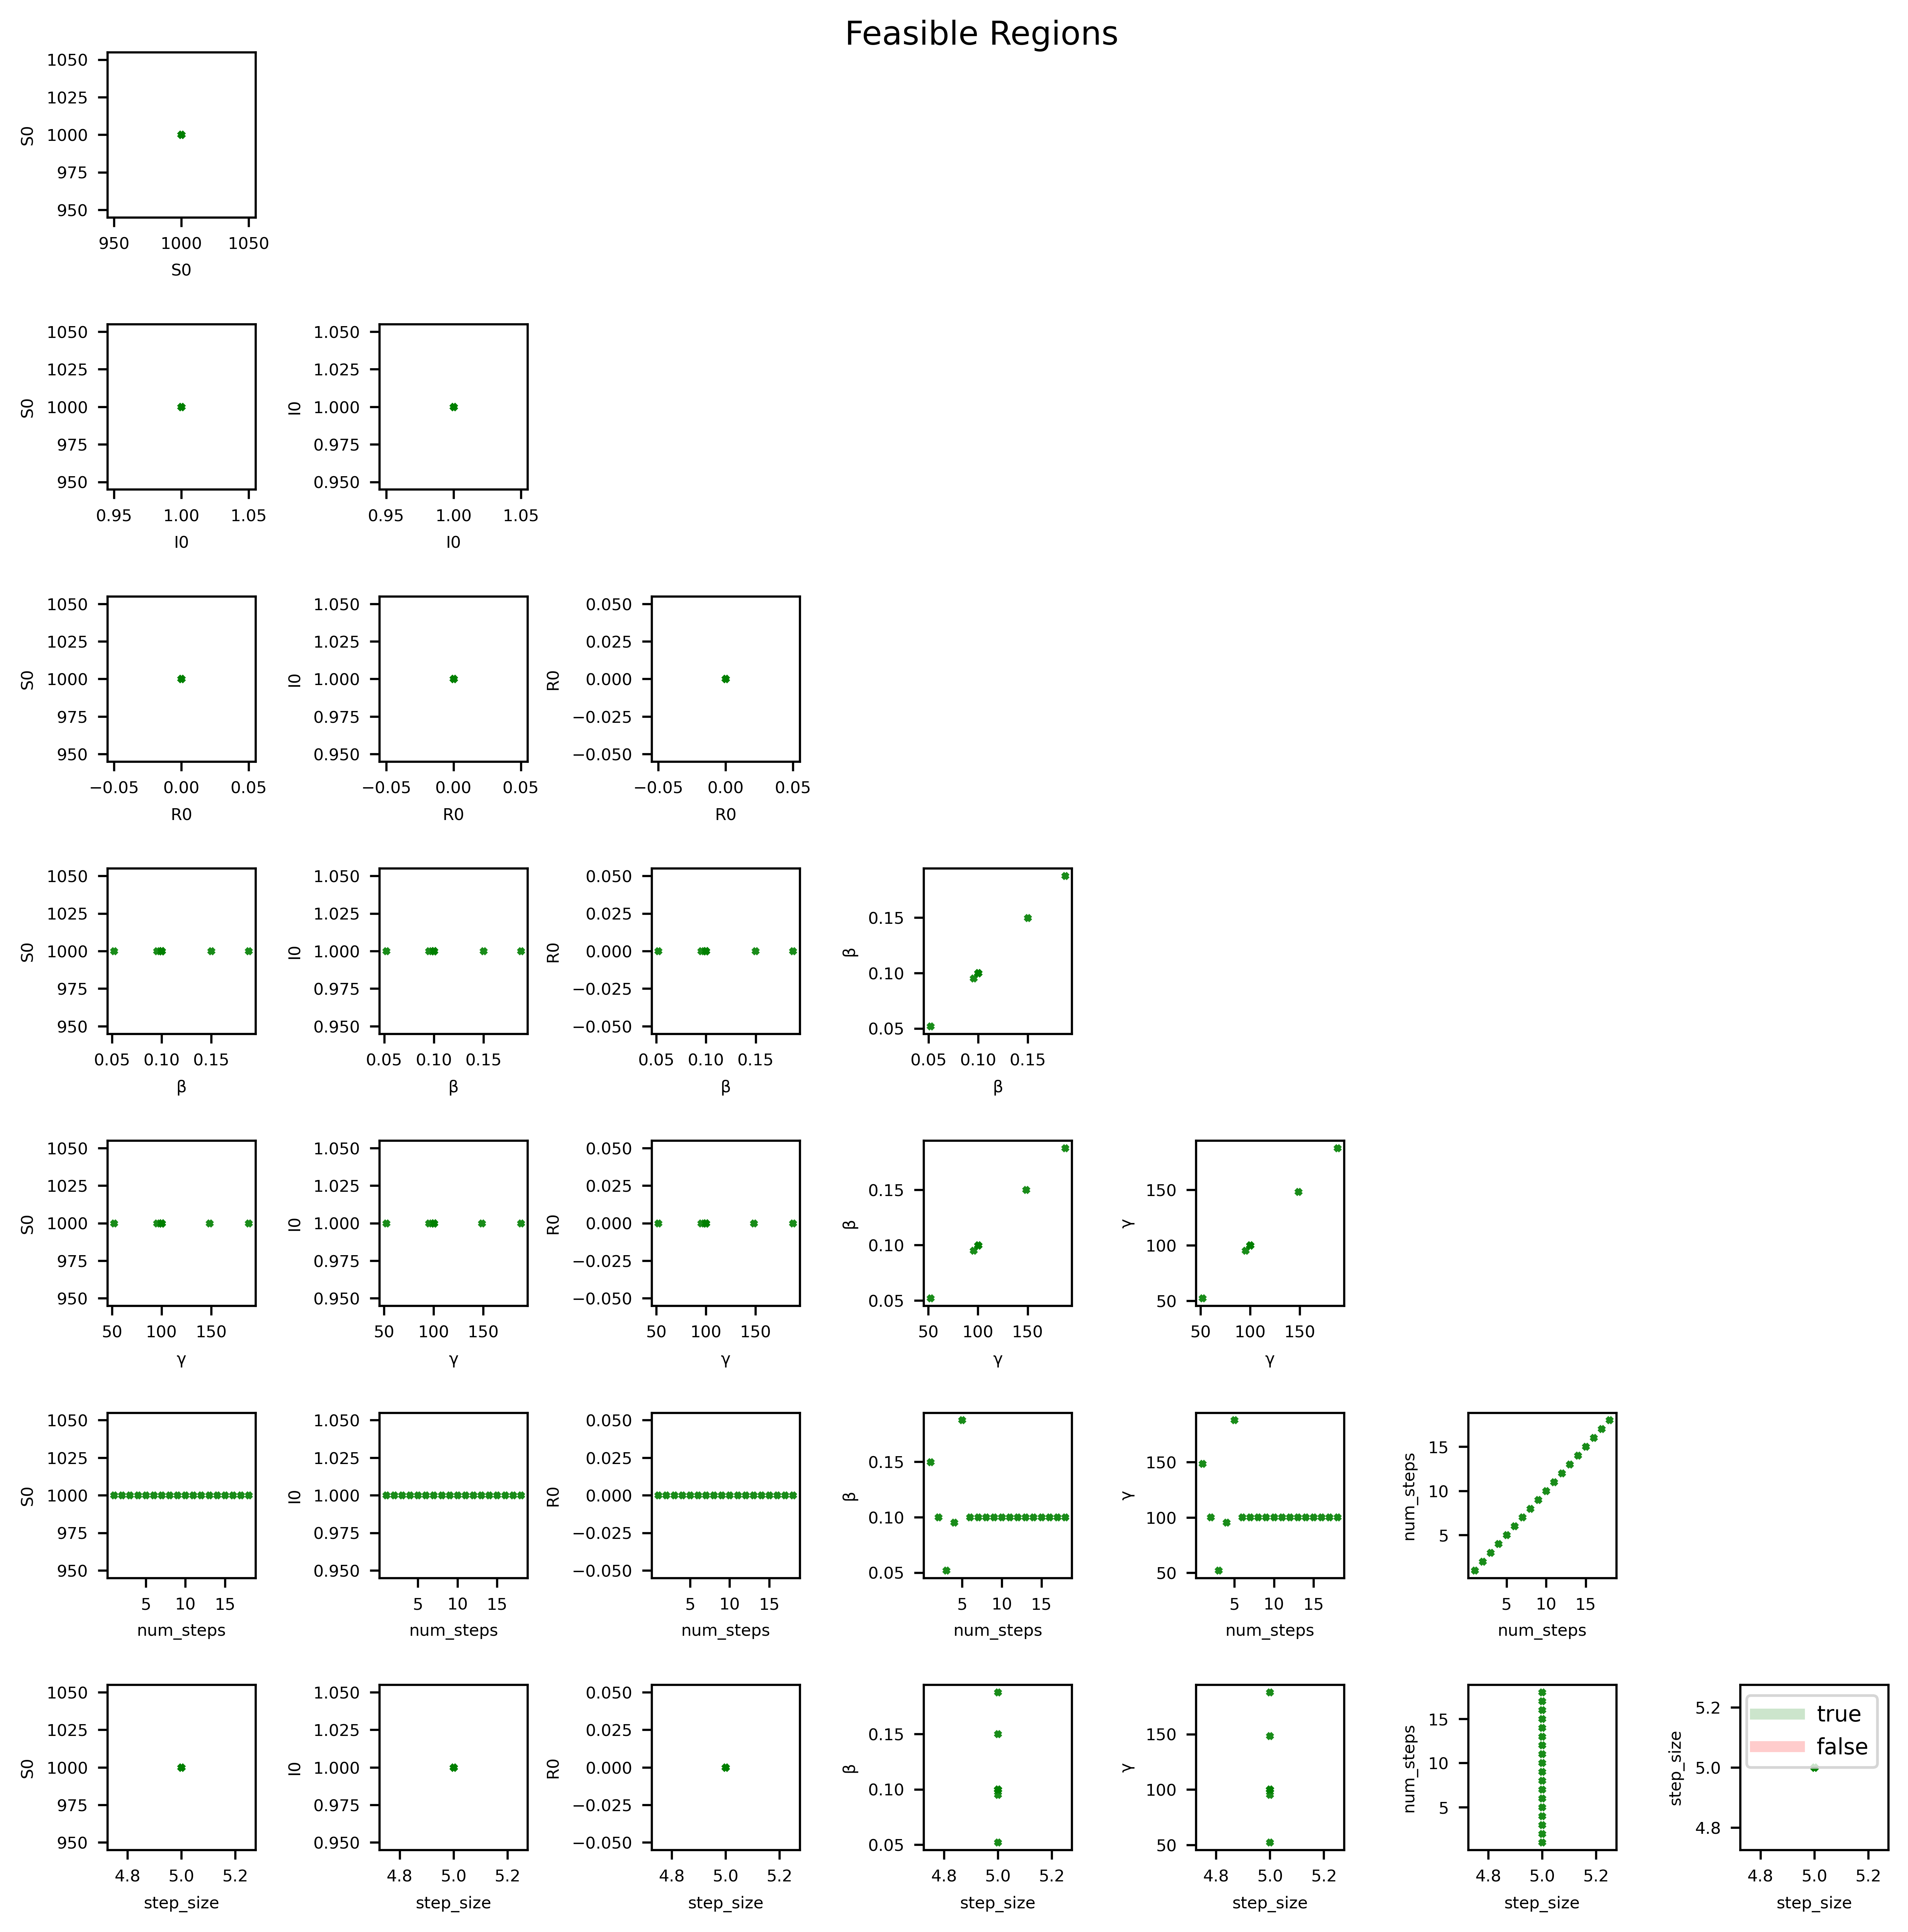

In [20]:
# Plot the ParameterSpace
from funman_demo.parameter_space_plotter import ParameterSpacePlotter
ParameterSpacePlotter(results.parameter_space, plot_points=True).plot(show=True)

# Example 1c: Optional: Halt Processing Job

In [ ]:
# Halt the current run
from funman_api_client.api.default import (
    halt_queries_query_id_halt_get
)

response = asyncio.run(
    halt_queries_query_id_halt_get.asyncio_detailed(
        client=funman_client,
        query_id=work_unit.id
    )
)

# The response returns a status
response

Response(status_code=<HTTPStatus.OK: 200>, content=b'"Success"', headers=Headers({'date': 'Tue, 27 Jun 2023 14:17:22 GMT', 'server': 'uvicorn', 'content-length': '9', 'content-type': 'application/json'}), parsed='Success')

# Example 2: AMR Regnet
---
## Example 2: Step 1: Load Model and Request

In [16]:
EXAMPLE_DIR = RESOURCES / "amr" / "regnet" / "amr-examples"
MODEL_PATH = EXAMPLE_DIR / "lotka_volterra.json"
REQUEST_PATH = EXAMPLE_DIR / "sir_request1.json"

# Read in the model file
model = json.loads(MODEL_PATH.read_bytes())
# pretty print
# print(json.dumps(model, indent=2))

# Read in the funman request file
request = json.loads(REQUEST_PATH.read_bytes())
# pretty print
print(json.dumps(request, indent=2))

{
  "query": {
    "queries": [
      {
        "variable": "R",
        "lb": 0.0
      },
      {
        "variable": "R",
        "ub": 100.0
      },
      {
        "variable": "W",
        "lb": 0.0
      },
      {
        "variable": "W",
        "ub": 1000.0
      }
    ]
  },
  "parameters": [
    {
      "name": "alpha",
      "lb": 0.667,
      "ub": 0.667,
      "label": "any"
    },
    {
      "name": "beta",
      "lb": 1.333,
      "ub": 1.333,
      "label": "all"
    },
    {
      "name": "gamma",
      "lb": 1,
      "ub": 1,
      "label": "any"
    },
    {
      "name": "delta",
      "lb": 1,
      "ub": 1,
      "label": "all"
    }
  ],
  "structure_parameters": [
    {
      "name": "num_steps",
      "lb": 1,
      "ub": 7,
      "label": "all"
    },
    {
      "name": "step_size",
      "lb": 1,
      "ub": 1,
      "label": "all"
    }
  ],
  "config": {}
}


## Example 2: Step 2: Submit job

In [31]:
# Make a POST request to the API endpoint
response = asyncio.run(
    post_queries_queries_post.asyncio_detailed(
        client=funman_client,
        json_body=BodyPostQueriesQueriesPost.from_dict({
            "model": model,
            "request": request
        }),
    )
)

# The response returns a work unit
work_unit = FunmanWorkUnit.from_dict(
    src_dict=json.loads(response.content.decode())
)
# Where the id can be used to pull ongoing results
work_unit.id

'8fb2ab35-6090-41d4-ad2c-177fffbb31c6'

## Example 2: Step 3: Request results

In [22]:
# Make a GET request to the API endpoint
response = asyncio.run(get_queries_queries_query_id_get.asyncio_detailed(
    work_unit.id,
    client=funman_client
))
# The response returns the latest funman results for the query
results = FunmanResults.from_dict(
    src_dict=json.loads(response.content.decode())
)
# pretty print the parameter_space
print(json.dumps(results.parameter_space.to_dict(), indent=2))

{
  "true_boxes": [],
  "false_boxes": [],
  "true_points": [],
  "false_points": []
}


## Example 2: Step 4: Plot Results

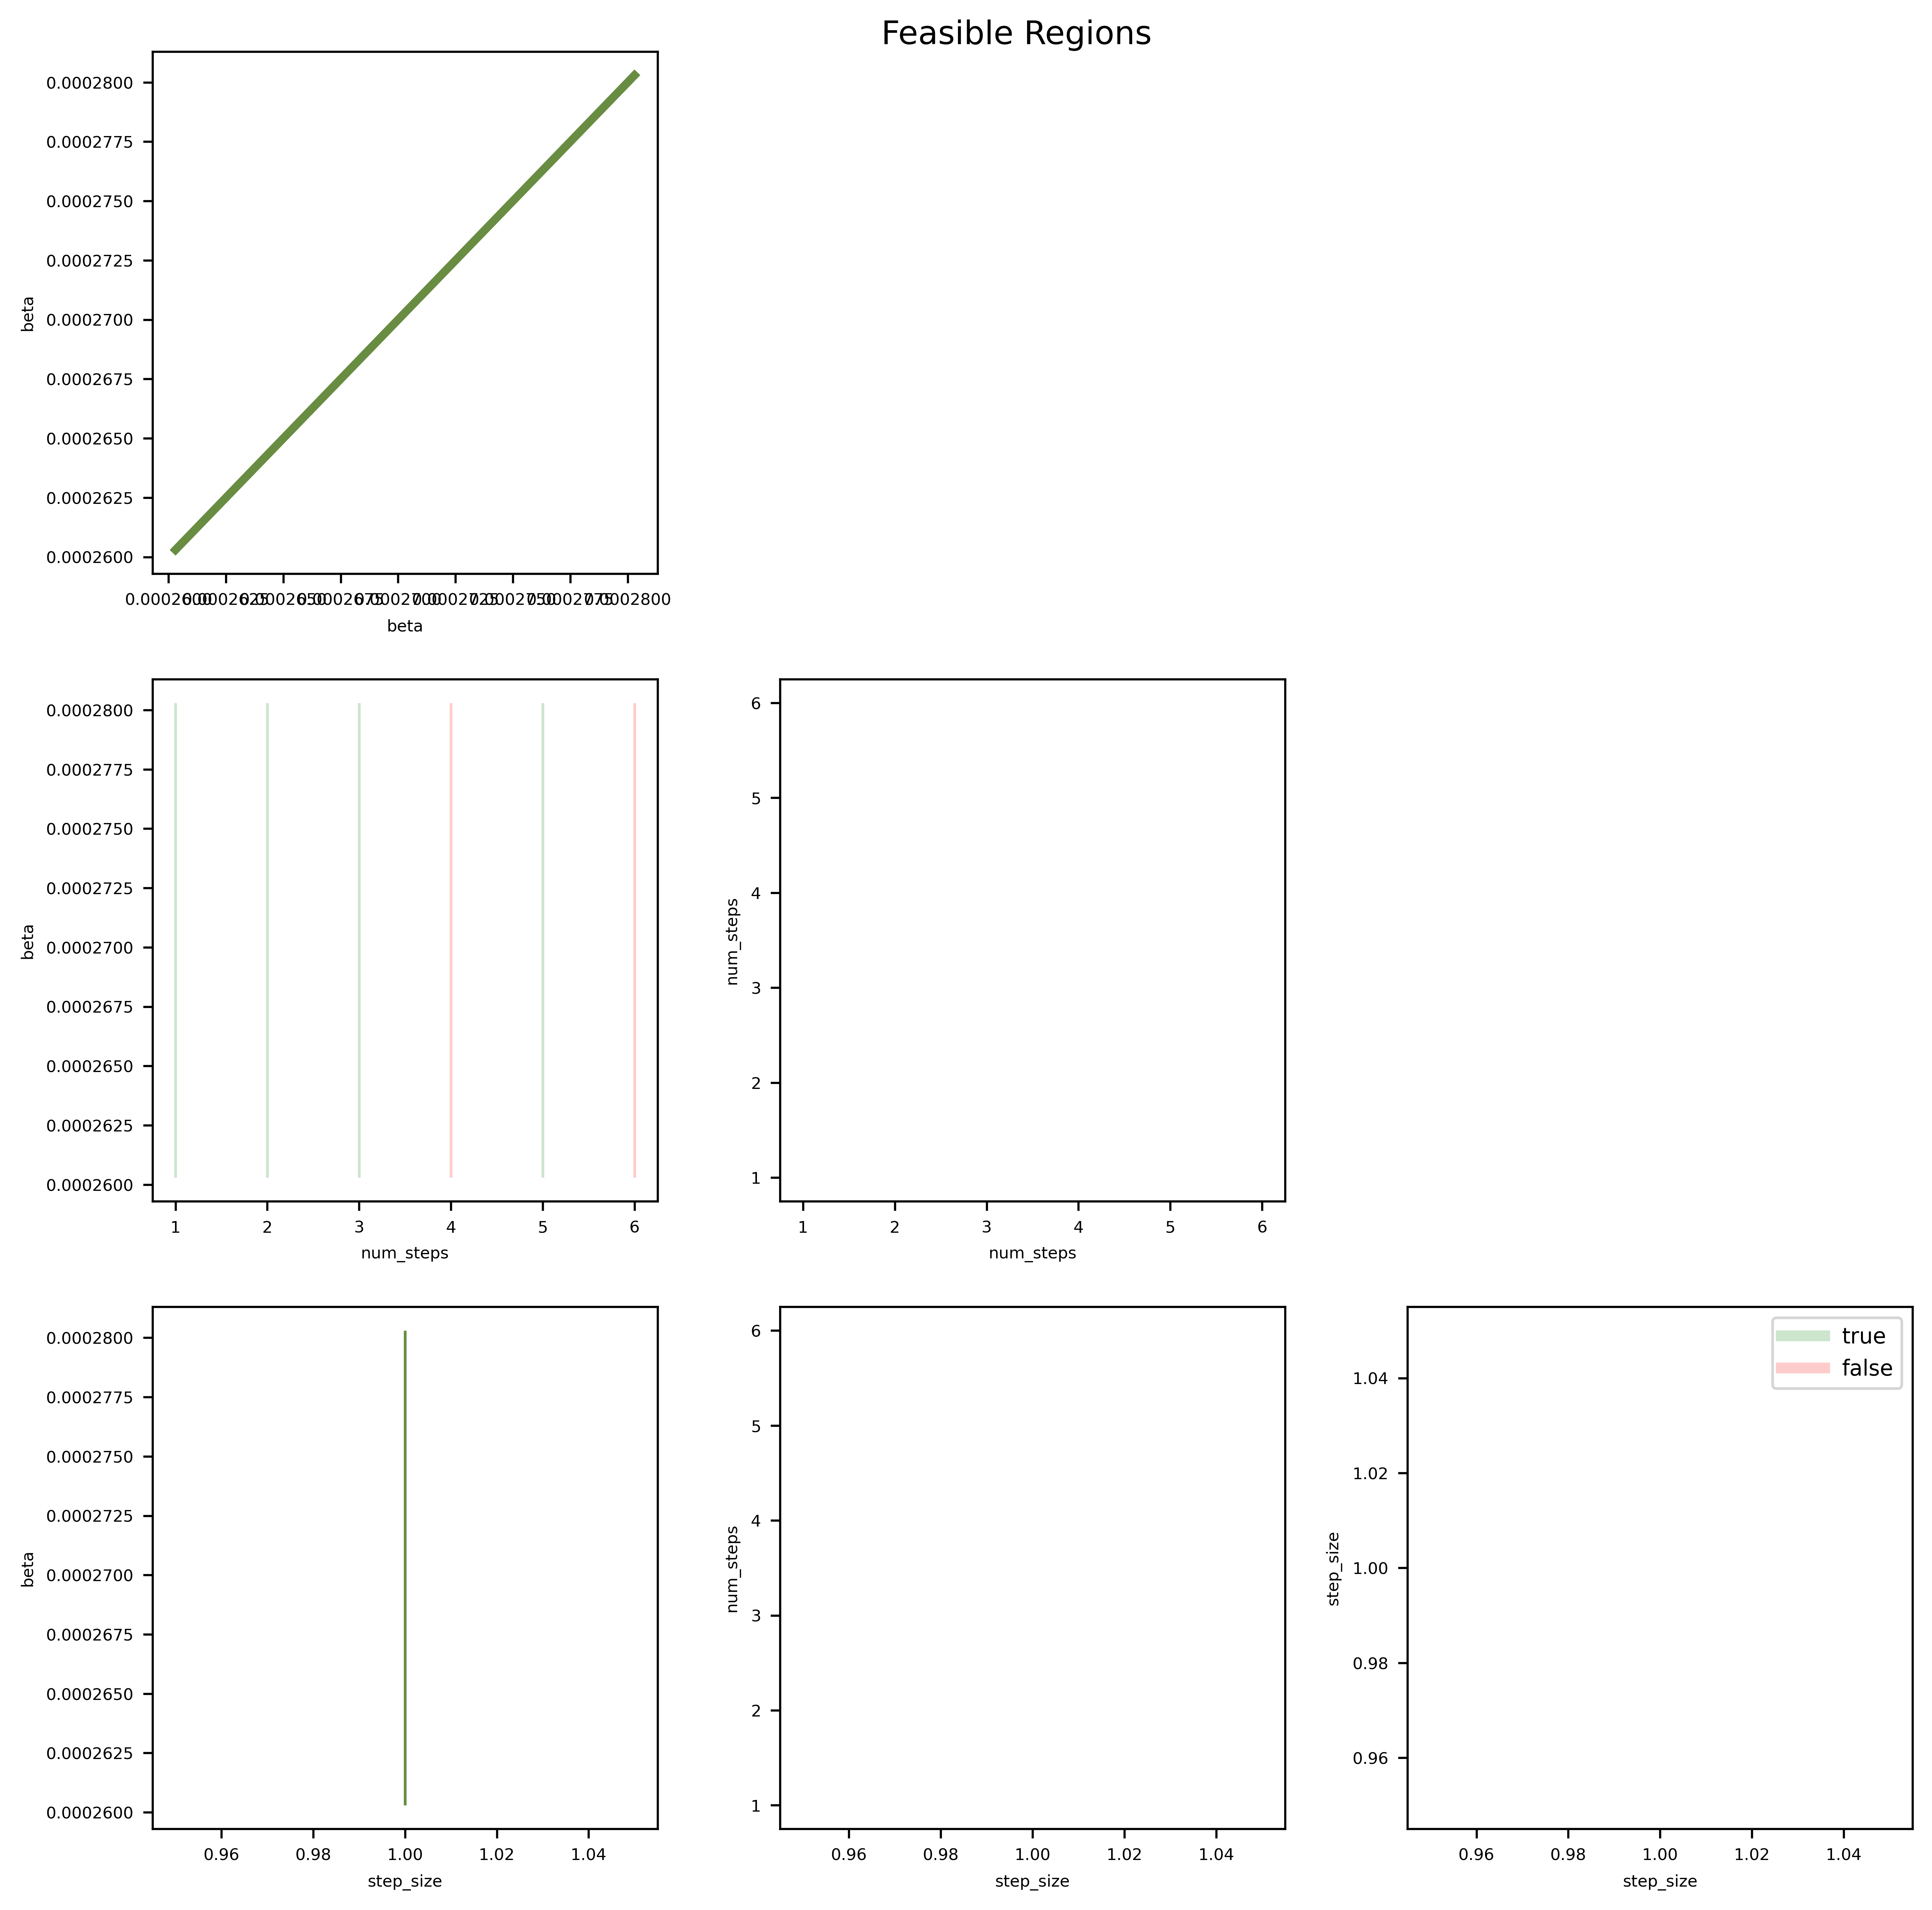

In [ ]:
# Plot the ParameterSpace
from funman_demo.parameter_space_plotter import ParameterSpacePlotter
ParameterSpacePlotter(results.parameter_space).plot(show=True)

# Optional: Halt Processing Job

In [12]:
# Halt the current run
from funman_api_client.api.default import (
    halt_queries_query_id_halt_get
)

response = asyncio.run(
    halt_queries_query_id_halt_get.asyncio_detailed(
        client=funman_client,
        query_id=work_unit.id
    )
)

# The response returns a status
response

Response(status_code=<HTTPStatus.OK: 200>, content=b'"Success"', headers=Headers({'date': 'Tue, 27 Jun 2023 14:17:22 GMT', 'server': 'uvicorn', 'content-length': '9', 'content-type': 'application/json'}), parsed='Success')